# Model Training Report

Load data, metrics, and visualizations for trained models.


In [7]:

import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_theme(style="whitegrid")


def find_project_root(start: Path) -> Path:
    for path in [start] + list(start.parents):
        if (path / "backend").exists() and (path / ".git").exists():
            return path
    raise RuntimeError("Could not locate the project root from the current directory.")


PROJECT_ROOT = find_project_root(Path.cwd())
BACKEND_DIR = PROJECT_ROOT / "backend"
if str(BACKEND_DIR) not in sys.path:
    sys.path.insert(0, str(BACKEND_DIR))

from app.ml.train_models import get_feature_groups, WeightedProbEnsemble  # noqa: E402

REPORTS_DIR = PROJECT_ROOT / "backend" / "app" / "ml" / "reports"
DATASET_PATH = PROJECT_ROOT / "backend" / "app" / "ml" / "data" / "processed" / "training_dataset.csv"


df = pd.read_csv(DATASET_PATH)
numeric_cols, diet_flag_cols, embed_cols = get_feature_groups(df)

with open(REPORTS_DIR / "model_comparison.json", "r") as f:
    model_results = json.load(f)

metrics_df = pd.DataFrame(model_results)
metrics_df



,name,accuracy,macro_f1
0,majority_baseline,0.584559,0.245940
1,nutrition_logreg,0.356618,0.344097
2,tfidf_logreg,0.404412,0.386403
3,oracle_knn_embeddings,0.367647,0.329201
4,sbert_fusion_mlp,0.455882,0.396934
5,sbert_fusion_linear,0.363971,0.354255


## Bar Chart - Model Accuracy Comparison


C:\Users\elong\AppData\Local\Temp\ipykernel_32984\2855851477.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, y="name", x="macro_f1", palette="viridis", ax=axes[0])
C:\Users\elong\AppData\Local\Temp\ipykernel_32984\2855851477.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, y="name", x="accuracy", palette="Blues_r", ax=axes[1])


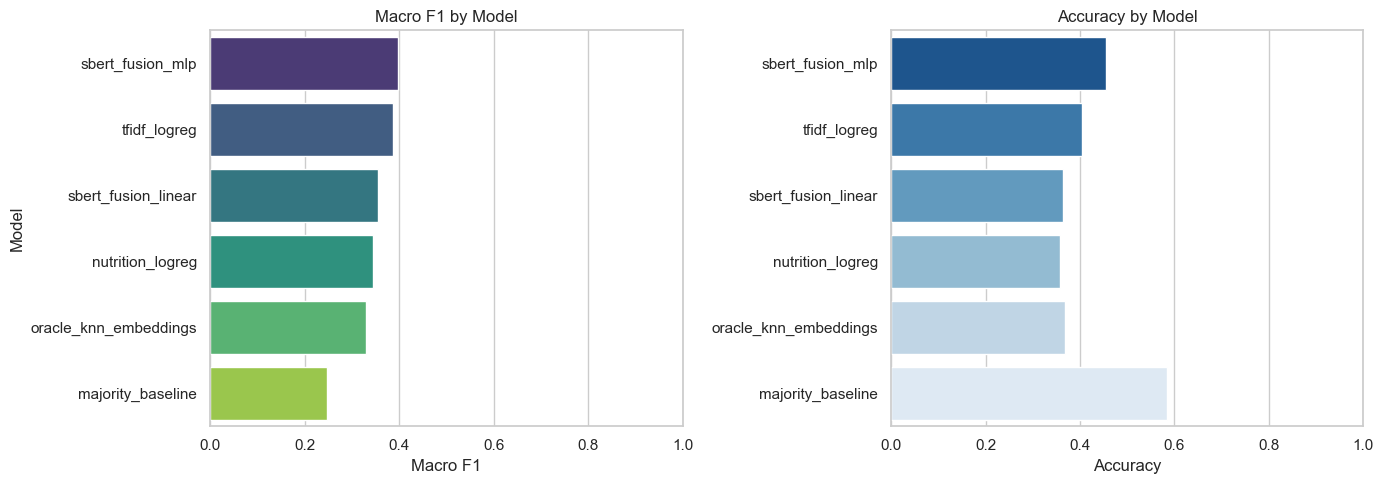

In [8]:

plot_df = metrics_df.sort_values(by="macro_f1", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=plot_df, y="name", x="macro_f1", palette="viridis", ax=axes[0])
axes[0].set_title("Macro F1 by Model")
axes[0].set_xlabel("Macro F1")
axes[0].set_ylabel("Model")
axes[0].set_xlim(0, 1)

sns.barplot(data=plot_df, y="name", x="accuracy", palette="Blues_r", ax=axes[1])
axes[1].set_title("Accuracy by Model")
axes[1].set_xlabel("Accuracy")
axes[1].set_ylabel("")
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()



## Confusion Matrix (per model)


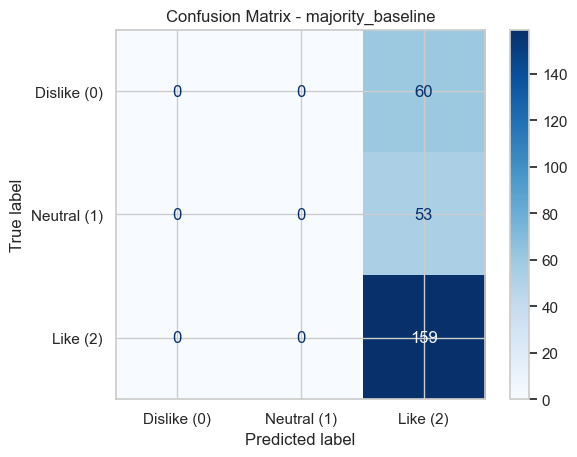

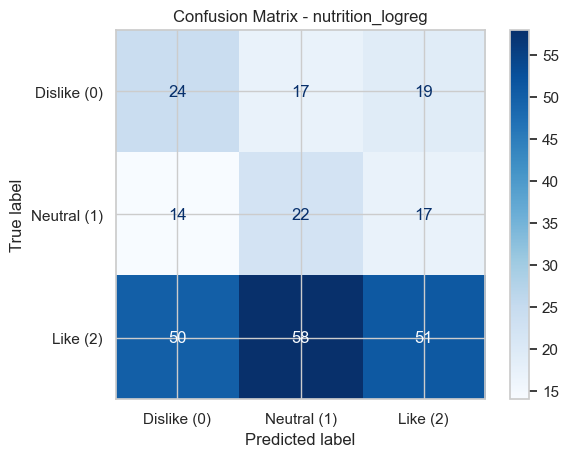

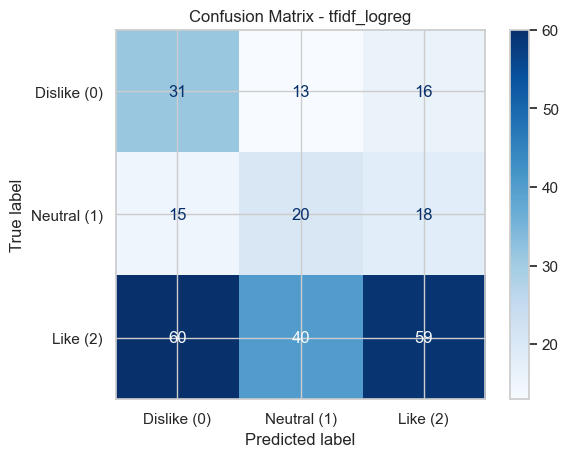

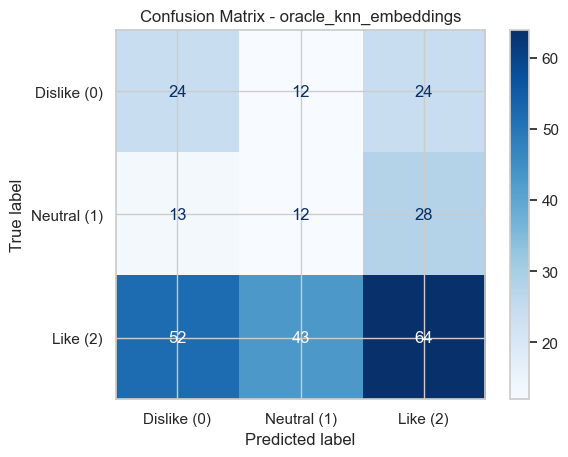

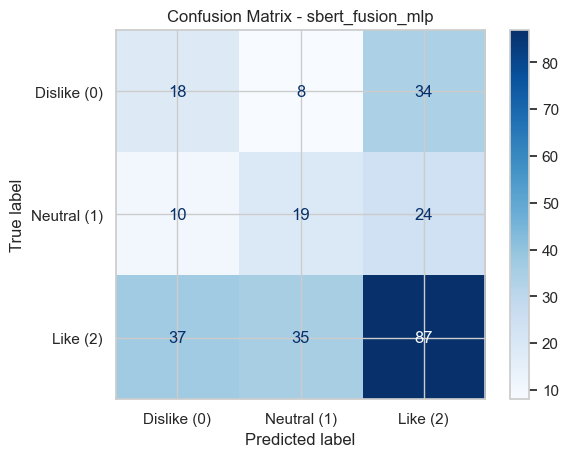

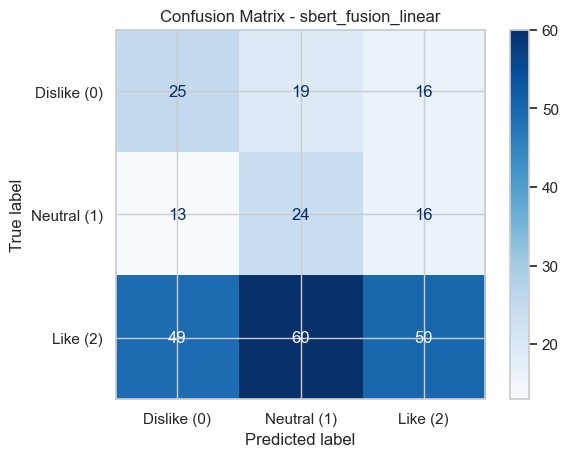

In [9]:

model_names = metrics_df["name"].tolist()

for model in model_names:
    path = REPORTS_DIR / f"{model}_report.json"
    if not path.exists():
        print(f"Skipping missing: {model}")
        continue

    with open(path, "r") as f:
        rep = json.load(f)

    cm = np.array(rep["confusion_matrix"])

    disp = ConfusionMatrixDisplay(
        cm, display_labels=["Dislike (0)", "Neutral (1)", "Like (2)"]
    )
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model}")
    plt.show()



## UMAP Visualization of Embeddings


c:\Users\elong\Desktop\Projects\RacerPlates\racer_plates_venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


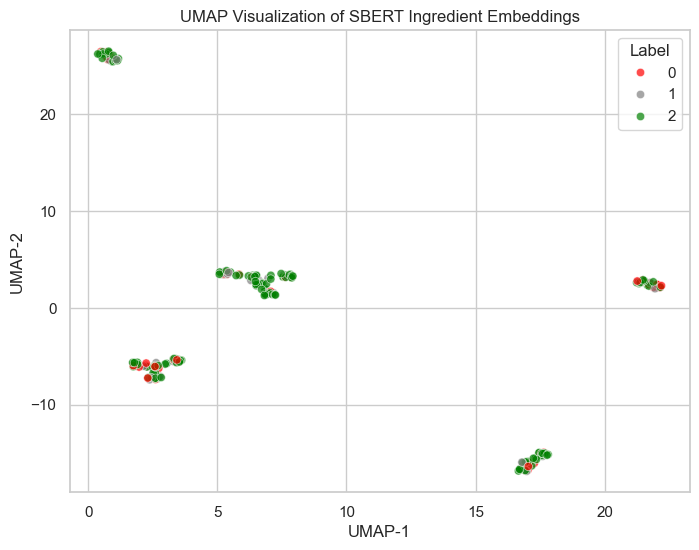

In [10]:
emb_cols = [c for c in df.columns if c.startswith("emb_")]
X_emb = df[emb_cols].values
labels = df["label_3class"].values

import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_emb)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=labels,
    palette={0: "red", 1: "gray", 2: "green"},
    alpha=0.7,
)
plt.title("UMAP Visualization of SBERT Ingredient Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Label")
plt.show()


## Feature Importance


C:\Users\elong\AppData\Local\Temp\ipykernel_32984\350379731.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_k, x="importance", y="feature", palette="viridis")


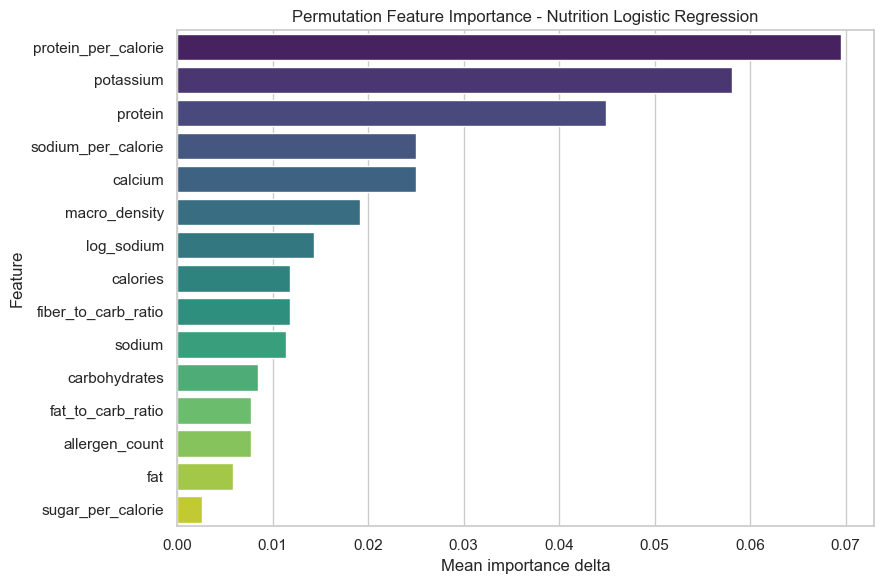

,feature,importance
12,protein_per_calorie,0.069485
10,potassium,0.058088
3,protein,0.044853
17,sodium_per_calorie,0.025000
9,calcium,0.025000
19,macro_density,0.019118
20,log_sodium,0.014338
0,calories,0.011765
16,fiber_to_carb_ratio,0.011765
5,sodium,0.011397


In [11]:

import joblib
from sklearn.inspection import permutation_importance

nutri_model_path = PROJECT_ROOT / "backend" / "app" / "ml" / "models" / "nutrition_logreg.joblib"
nutri = joblib.load(nutri_model_path)

X_numeric = df[numeric_cols]
y = df["label_3class"]

result = permutation_importance(
    nutri,
    X_numeric,
    y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

importance_df = (
    pd.DataFrame({"feature": numeric_cols, "importance": result.importances_mean})
    .sort_values(by="importance", ascending=False)
)

top_k = importance_df.head(15)

plt.figure(figsize=(9, 6))
sns.barplot(data=top_k, x="importance", y="feature", palette="viridis")
plt.title("Permutation Feature Importance - Nutrition Logistic Regression")
plt.xlabel("Mean importance delta")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

top_k



## Error Analysis Table


In [12]:

import joblib

fusion_model_path = PROJECT_ROOT / "backend" / "app" / "ml" / "models" / "sbert_fusion_mlp.joblib"
fusion = joblib.load(fusion_model_path)

feature_cols = numeric_cols + diet_flag_cols + embed_cols

X = df[feature_cols]
fusion_true = df["label_3class"].to_numpy()
fusion_pred = fusion.predict(X)
fusion_proba = fusion.predict_proba(X)

errors = df.copy()
errors["true"] = fusion_true
errors["pred"] = fusion_pred
errors["confidence"] = fusion_proba.max(axis=1)
errors["correct"] = errors["true"] == errors["pred"]

mis = errors[~errors["correct"]].copy()
mis_small = mis[
    [
        "meal_id",
        "menu_item_id",
        "label_3class",
        "stars_5",
        "calories",
        "fat",
        "sugar",
        "protein",
        "allergen_count",
        "true",
        "pred",
        "confidence",
    ]
].sort_values(by="confidence")

mis_small.head(25)



,meal_id,menu_item_id,label_3class,stars_5,calories,fat,sugar,protein,allergen_count,true,pred,confidence
15,156,6991787241,0,2,370.0,20.0,0.0,19.0,3,0,2,0.387808
47,156,6991787241,0,2,370.0,20.0,0.0,19.0,3,0,2,0.387808
63,156,6991787241,1,3,370.0,20.0,0.0,19.0,3,1,2,0.387808
79,156,6991787241,1,3,370.0,20.0,0.0,19.0,3,1,2,0.387808
143,156,6991787241,0,2,370.0,20.0,0.0,19.0,3,0,2,0.387808
271,156,6991787241,0,1,370.0,20.0,0.0,19.0,3,0,2,0.387808
87,107,6991787210,2,4,180.0,8.0,1.0,18.0,3,2,0,0.390922
39,107,6991787210,1,3,180.0,8.0,1.0,18.0,3,1,0,0.390922
103,107,6991787210,2,4,180.0,8.0,1.0,18.0,3,2,0,0.390922
119,107,6991787210,2,4,180.0,8.0,1.0,18.0,3,2,0,0.390922
